<a href="https://colab.research.google.com/github/emilyswitzer/celeb-heights/blob/main/celebs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [ ]:
!unzip "/content/Validation.zip" -d "/content/validation"

Archive:  /content/Validation.zip
  inflating: /content/validation/106/Phil Fondacaro.jpg  
  inflating: /content/validation/106/Tony Cox.jpg  
  inflating: /content/validation/106/Warwick Davis.jpg  
  inflating: /content/validation/109/Michael J Anderson.jpg  
  inflating: /content/validation/111/Jimmy Vee.jpg  
  inflating: /content/validation/111/Kenny Baker.jpg  
  inflating: /content/validation/114/Billy Barty.jpg  
  inflating: /content/validation/116/Herve Villechaize.jpg  
  inflating: /content/validation/119/Danny Woodburn.jpg  
  inflating: /content/validation/119/David Rappaport.jpg  
  inflating: /content/validation/121/Leigh Gill.jpg  
  inflating: /content/validation/121/Martin Klebba.jpg  
  inflating: /content/validation/121/Meredith Eaton.jpg  
  inflating: /content/validation/125/Kiran Shah.jpg  
  inflating: /content/validation/127/Rusty Goffe.jpg  
  inflating: /content/validation/127/Sam Humphrey.jpg  
  inflating: /content/validation/129/Beetlejuice.jpg  
  infla

In [ ]:
!unzip "/content/Validation.zip" -d "/content/train"

Archive:  /content/Validation.zip
  inflating: /content/train/106/Phil Fondacaro.jpg  
  inflating: /content/train/106/Tony Cox.jpg  
  inflating: /content/train/106/Warwick Davis.jpg  
  inflating: /content/train/109/Michael J Anderson.jpg  
  inflating: /content/train/111/Jimmy Vee.jpg  
  inflating: /content/train/111/Kenny Baker.jpg  
  inflating: /content/train/114/Billy Barty.jpg  
  inflating: /content/train/116/Herve Villechaize.jpg  
  inflating: /content/train/119/Danny Woodburn.jpg  
  inflating: /content/train/119/David Rappaport.jpg  
  inflating: /content/train/121/Leigh Gill.jpg  
  inflating: /content/train/121/Martin Klebba.jpg  
  inflating: /content/train/121/Meredith Eaton.jpg  
  inflating: /content/train/125/Kiran Shah.jpg  
  inflating: /content/train/127/Rusty Goffe.jpg  
  inflating: /content/train/127/Sam Humphrey.jpg  
  inflating: /content/train/129/Beetlejuice.jpg  
  inflating: /content/train/129/Zelda Rubinstein.jpg  
  inflating: /content/train/130/Jason

In [ ]:
import pathlib

data_dir = "data/train/"
data_dir = pathlib.Path(data_dir)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2166


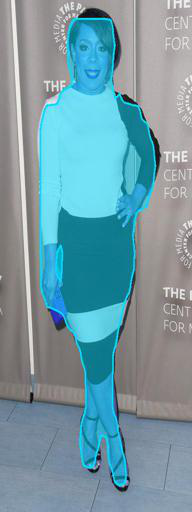

In [ ]:
person = list(data_dir.glob('161/*'))
PIL.Image.open(str(person[10]))

And some tulips:

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 512
img_width = 94

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2166 files belonging to 78 classes.
Using 1733 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2166 files belonging to 78 classes.
Using 433 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['106', '109', '111', '114', '116', '119', '121', '125', '127', '129', '130', '132', '139', '146', '147', '148', '149', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '81']


## Visualize the data

Here are the first nine images from the training dataset:

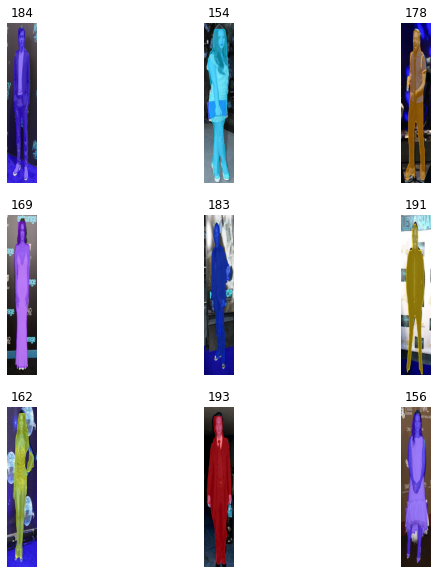

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 94, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [ ]:
model.summary()

ValueError: ignored

## Train the model

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
55/55 [==============================] - 4s 71ms/step - loss: 0.0052 - accuracy: 0.9994 - val_loss: 11.6801 - val_accuracy: 0.0462
Epoch 2/20
55/55 [==============================] - 4s 65ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 12.3728 - val_accuracy: 0.0439
Epoch 3/20
55/55 [==============================] - 4s 65ms/step - loss: 5.7718e-04 - accuracy: 1.0000 - val_loss: 12.7560 - val_accuracy: 0.0416
Epoch 4/20
55/55 [==============================] - 4s 65ms/step - loss: 4.2513e-04 - accuracy: 1.0000 - val_loss: 13.0036 - val_accuracy: 0.0462
Epoch 5/20
55/55 [==============================] - 4s 65ms/step - loss: 3.3742e-04 - accuracy: 1.0000 - val_loss: 13.2123 - val_accuracy: 0.0462
Epoch 6/20
55/55 [==============================] - 4s 65ms/step - loss: 2.7694e-04 - accuracy: 1.0000 - val_loss: 13.3957 - val_accuracy: 0.0462
Epoch 7/20
55/55 [==============================] - 4s 64ms/step - loss: 2.3212e-04 - accuracy: 1.0000 - val_loss: 13.5631 - val_acc

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

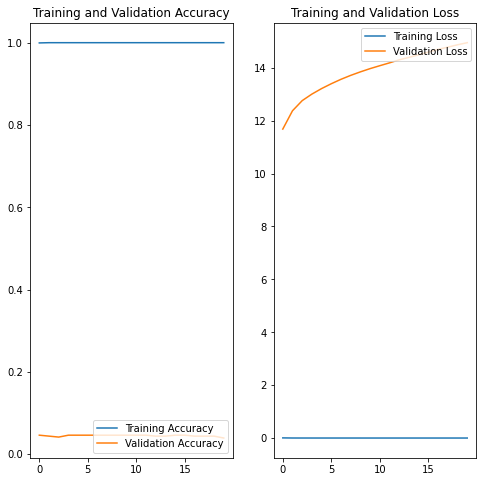

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

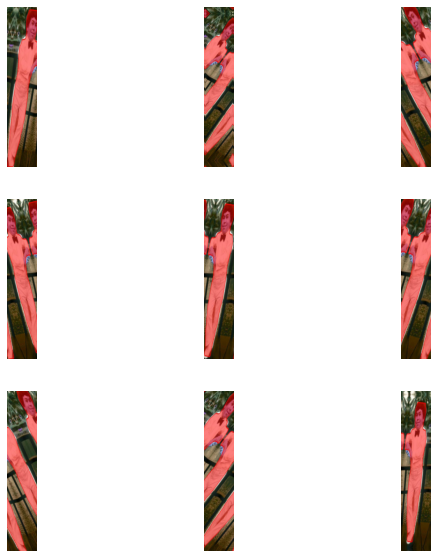

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
 # layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
55/55 [==============================] - 5s 78ms/step - loss: 35.3000 - accuracy: 0.0300 - val_loss: 4.0245 - val_accuracy: 0.0323
Epoch 2/15
55/55 [==============================] - 4s 73ms/step - loss: 3.9886 - accuracy: 0.0340 - val_loss: 3.9766 - val_accuracy: 0.0346
Epoch 3/15
55/55 [==============================] - 4s 73ms/step - loss: 3.9486 - accuracy: 0.0358 - val_loss: 3.9477 - val_accuracy: 0.0208
Epoch 4/15
55/55 [==============================] - 4s 73ms/step - loss: 3.9384 - accuracy: 0.0392 - val_loss: 3.9510 - val_accuracy: 0.0254
Epoch 5/15
55/55 [==============================] - 4s 73ms/step - loss: 3.9192 - accuracy: 0.0450 - val_loss: 3.9617 - val_accuracy: 0.0300
Epoch 6/15
55/55 [==============================] - 4s 72ms/step - loss: 3.9047 - accuracy: 0.0467 - val_loss: 3.9503 - val_accuracy: 0.0370
Epoch 7/15
55/55 [==============================] - 4s 72ms/step - loss: 3.9125 - accuracy: 0.0433 - val_loss: 3.9627 - val_accuracy: 0.0370
Epoch 8/15
5

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

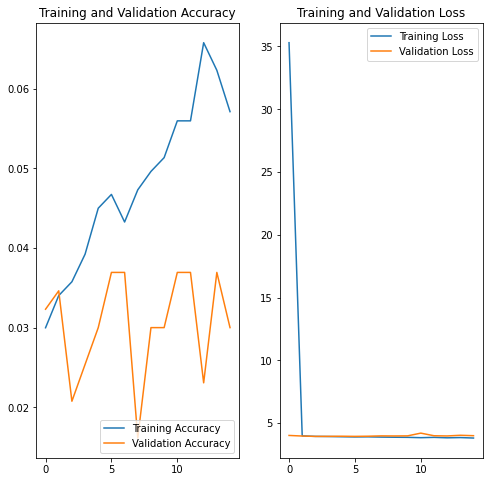

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

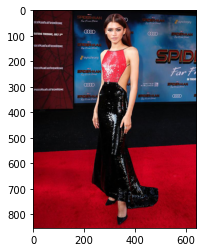

This image most likely belongs to 152 with a 28.36 percent confidence.


In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/zendayaaa.jfif')
imgplot = plt.imshow(img)
plt.show()
sunflower_path = '/content/zendayaaa.jfif'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)